In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

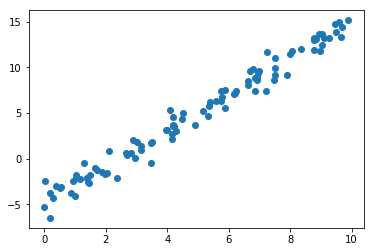

In [77]:
np.random.seed(1)
x = 10 * np.random.rand(100)
y = 2 * x - 5 + np.random.randn(100) 
# np.random.rand(100) - 100 samples from random numbers from 0 to 1
# np.random.randn(100) - noise (100 samples from the “standard normal” distribution)
plt.scatter(x, y);

In [23]:
y.shape

(100,)

In [24]:
x[ :, np.newaxis].shape

(100, 1)

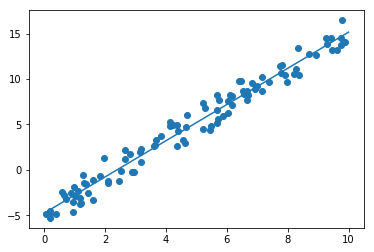

In [25]:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(x[ :, np.newaxis], y)

# np.linspace - return evenly spaced numbers over a specified interval
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [26]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     1.9936935021402045
Model intercept: -4.777848922552774


We see that the results are very close to the inputs, as we might hope.

## Model validation

For linear regression a model score is R² score (the coefficient of determination). Best possible score is 1.0.

http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score

In [27]:
model.score(x[:, np.newaxis], y)

0.970836551261775

In [28]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(x[:, np.newaxis], y, random_state=2)
print(Xtrain.shape, Xtest.shape)

(75, 1) (25, 1)


In [29]:
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
model.score(Xtest, ytest)

0.9669510235427151

## Regression metrics
http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [32]:
ytest_pred = model.predict(Xtest)

In [33]:
print("Mean absolute error", mean_absolute_error(ytest, ytest_pred))
print("Mean square error", mean_squared_error(ytest, ytest_pred))

Mean absolute error 0.8763353267915069
Mean square error 1.0437051556921808


## Basis Function Regression

In addition to simple straight-line fits the ``LinearRegression`` estimator can handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.
One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.

The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [34]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4]).reshape(3,1)
poly = PolynomialFeatures(3)
poly.fit_transform(x)

array([[ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

This new, higher-dimensional data representation can then be plugged into a linear regression.

Let's make a 7th-degree polynomial model in this way:

In [52]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

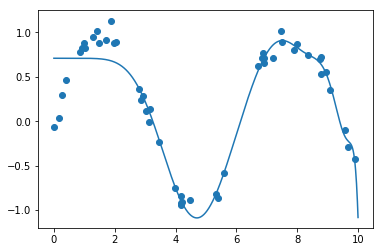

In [78]:
np.random.seed(1)
x = 10 * np.random.rand(50)
y = np.sin(x) + 0.1 * np.random.randn(50)
plt.scatter(x, y)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting. 

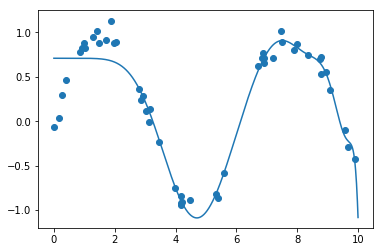

In [79]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(18),
                           LinearRegression())

np.random.seed(1)
x = 10 * np.random.rand(50)
y = np.sin(x) + 0.1 * np.random.randn(50)
plt.scatter(x, y)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit);

With the data projected to the 18-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

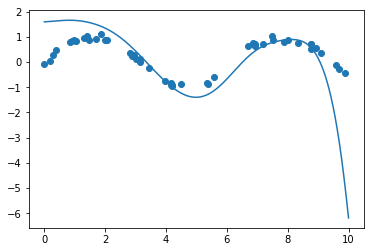

In [80]:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

from sklearn.linear_model import Ridge
model = make_pipeline(PolynomialFeatures(18), Ridge(alpha=0.1))

np.random.seed(1)
x = 10 * np.random.rand(50)
y = np.sin(x) + 0.1 * np.random.randn(50)
plt.scatter(x, y)

model.fit(x[:, np.newaxis], y)
yfit = model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit);

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


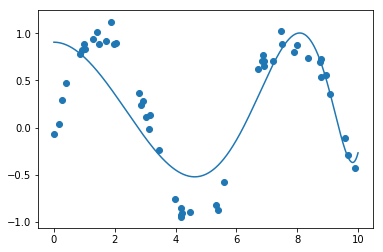

In [81]:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

from sklearn.linear_model import Lasso
model = make_pipeline(PolynomialFeatures(18), Lasso(alpha=0.1))

np.random.seed(1)
x = 10 * np.random.rand(50)
y = np.sin(x) + 0.1 * np.random.randn(50)
plt.scatter(x, y)

model.fit(x[:, np.newaxis], y)
yfit = model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit);